<a href="https://colab.research.google.com/github/sakuragi97/NLP-Fake-News/blob/master/NLP_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION
**Les fausses nouvelles font référence à la désinformation, à la désinformation ou aux informations erronées qui se propagent par le bouche à oreille et les médias traditionnels et, plus récemment, par des formes de communication numériques telles que des vidéos éditées, des mèmes, des publicités non vérifiées et des rumeurs propagées par les médias sociaux. les médias sociaux sont devenus un problème grave, avec le potentiel de se traduire par de la violence de la foule, des suicides, etc. en raison de la désinformation diffusée sur les médias sociaux.**

## BREVE DESCRIPTION DU DATASET
Cet ensemble de données se compose d'environ 40000 articles composés de fausses et de vraies nouvelles. Notre objectif est de former notre modèle afin qu'il puisse prédire correctement si une information donnée est réelle ou fausse.Les données fictives et réelles sont fournies dans deux ensembles de données distincts, chaque ensemble de données comprenant environ 20000 articles chacun.

---

In [ ]:
#linking with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

In [6]:
# Donwloading All Dataset Using Kaggle API 
#!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
#!kaggle datasets download -d icw123/glove-twitter

In [7]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

# CHARGEMENT DES BIBLIOTHEQUES NECESSAIRES

---

In [ ]:
import numpy as np # Library for linear algebra and matrices
import pandas as pd # data processing

#Plot and Visualising libraries
import seaborn as sns
import matplotlib.pyplot as plt

#NLTK / SKLEARN / KERAS / TENSORFLOW Libraries 
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize


from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [ ]:
!ls


# IMPORTATION DU DATASET

In [10]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

# VISUALISATION ET PRÉ-TRAITEMENT DES DONNÉES

In [11]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
true['category'] = 1
false['category'] = 0

In [14]:
df = pd.concat([true,false])

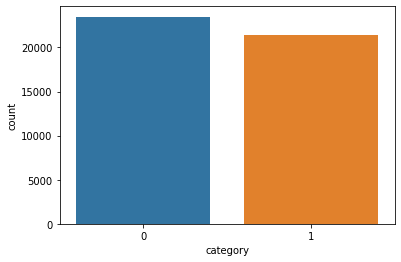

In [15]:
sns.countplot(df.category)

 **ON PEUT VOIR QUE LE DATASET EST ÉQUILIBRÉ**

In [16]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [17]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [18]:
df.count()

title       44898
text        44898
subject     44898
date        44898
category    44898
dtype: int64

In [19]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

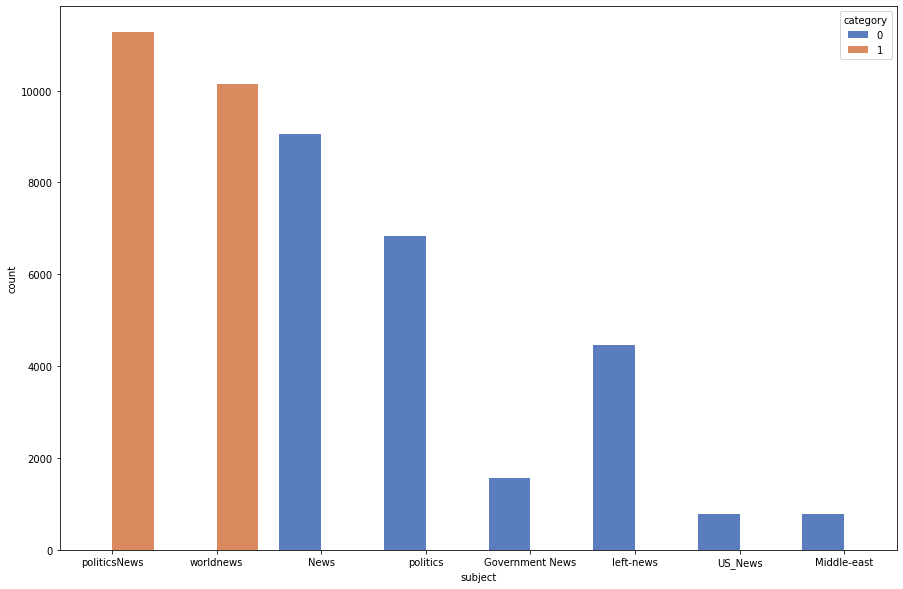

In [20]:
plt.figure(figsize = (15,10))
chart = sns.countplot(x = "subject", hue = "category" , data = df , palette = 'muted')

**PUISQUE LES SUJETS DE LA COLONNE "SUBJECT" SONT DIFFÉRENTS POUR LES DEUX CATÉGORIES, NOUS DEVONS EXCLURE DE LA COLONNE DE "TEXT" FINAL**

In [21]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**QU'EST-CE QUE LES STOPWORDS?**

**Les "STOPWORDS" sont les mots vides, les mots anglais qui n'ajoutent pas beaucoup de sens à une phrase. Ils peuvent être ignorés en toute sécurité sans sacrifier le sens de la phrase. Par exemple, les mots comme le, il, ont etc. De tels mots sont déjà capturés dans le corpus nommé corpus. Nous le téléchargeons d'abord dans notre environnement python.**

In [22]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [23]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
# nltk.download('string')

stopwordset = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopwordset.update(punctuation)
print(stopwordset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'from', 'do', 'as', 'aren', 'her', 'few', "'", 'of', "doesn't", "isn't", 'you', 'needn', "should've", 'through', 'out', 'weren', 'it', '/', 'yours', "that'll", '`', 'theirs', 'me', 'some', 'd', 'will', 'hers', 'is', 'further', 'll', '.', 'y', 'doing', 'there', 'same', "hasn't", ',', "weren't", 'nor', 'his', 'under', '<', 'which', "she's", 'shan', "couldn't", 'wouldn', '"', 'down', 'who', 'again', 'off', 'in', '_', '#', "you'll", 'have', 'having', 'to', 'doesn', 'why', 've', 'wasn', 'such', 'does', 'before', 'whom', 'myself', 'i', 'at', 'hasn', 'those', '?', 'haven', "wasn't", 'mightn', '!', 'so', 'are', 'very', 'while', 'they', 'himself', 'not', 'we', 'should', '=', '[', 'most', 'or', 'no', 'because', "didn't", '*', 'shouldn', 'couldn', "aren't", '{', 'about', 'up', 'has', 'won', 'him', 'these', 'after', 'herself', 'where', 'how', 'that', 'only', 'don', 'now', 'been', "don't"

**DATA CLEANING**

In [24]:
from bs4 import BeautifulSoup
import re,string,unicodedata

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text) #Regular Expression

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text) #Regular Expression

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwordset:
            final_text.append(i.strip())
    return " ".join(final_text)

#Summing up the previous functions
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on text column
df['text']=df['text'].apply(denoise_text)

**Diviser les données en 2 parties - données d'entraînement et de test**

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [26]:
max_features = 10000
maxlen = 300

**Texte de tokenisation : Représenter chaque mot par un nombre**

**Tokenized applique un traitement de base comme le changer en minuscules, en définissant explicitement cela comme False**

**Permet de garder toutes les "news" à 300, d'ajouter du rembourrage aux nouvelles avec moins de 300 mots et de tronquer les longs**

In [27]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [28]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

#GloVe: Global Vectors for Word Representation
**GloVe est un algorithme d'apprentissage non supervisé permettant d'obtenir des représentations vectorielles des mots. La formation est effectuée sur des statistiques globales de co-occurrence mot-mot d'un corpus, et les représentations résultantes présentent des sous-structures linéaires intéressantes de l'espace vectoriel de mots.**

In [29]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

In [30]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

**Certains paramètres du modèle**

In [32]:
batch_size = 256
epochs = 10
embed_size = 100

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING DU MODÈLE

In [34]:
#Neural Network
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [36]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 134s 4ms/step - loss: 0.1560 - accuracy: 0.9386 - val_loss: 0.0638 - val_accuracy: 0.9783
Epoch 2/10
33673/33673 [==============================] - 132s 4ms/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 0.0182 - val_accuracy: 0.9938
Epoch 3/10
33673/33673 [==============================] - 132s 4ms/step - loss: 0.0228 - accuracy: 0.9922 - val_loss: 0.0167 - val_accuracy: 0.9949
Epoch 4/10
33673/33673 [==============================] - 132s 4ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0099 - val_accuracy: 0.9966
Epoch 5/10
33673/33673 [==============================] - 130s 4ms/step - loss: 0.0081 - accuracy: 0.9972 - val_loss: 0.0056 - val_accuracy: 0.9983
Epoch 6/10
33673/33673 [==============================] - 130s 4ms/step - loss: 0.0081 - accuracy: 0.9971 - val_loss: 0.0072 - val_accuracy: 0.9980
Epoch 7/10
33673/33673 [==============================] - 131s

# ANALYSE APRÈS TRAINING DU MODÈLE

In [37]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

33673/33673 [==============================] - 87s 3ms/step
Accuracy of the model on Training Data is -  99.99406337738037
11225/11225 [==============================] - 29s 3ms/step
Accuracy of the model on Testing Data is -  99.83073472976685


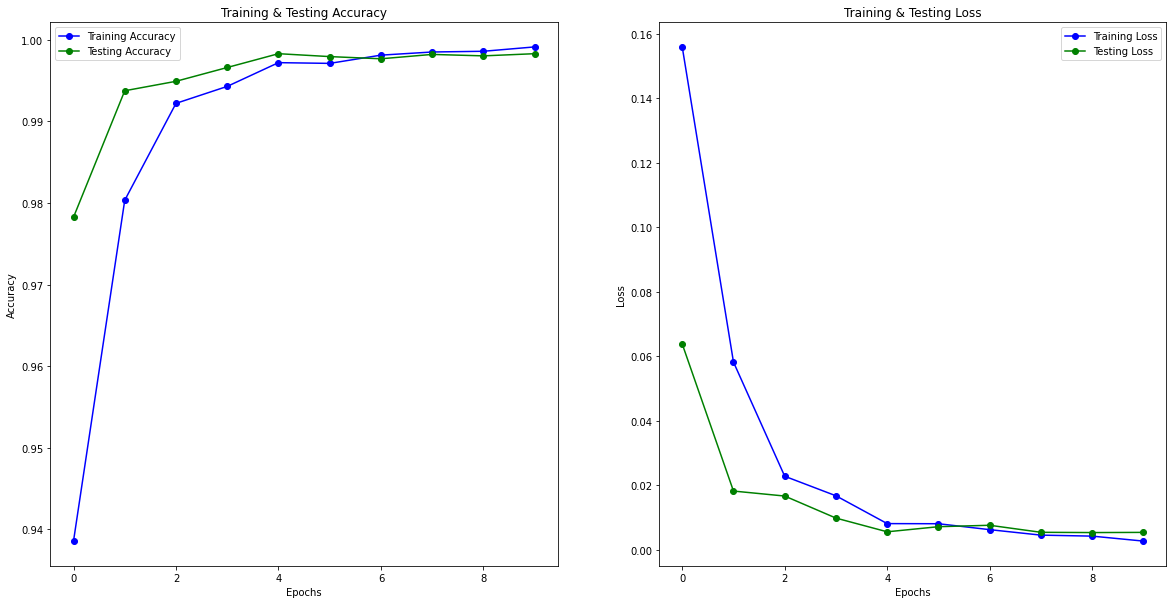

In [45]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'bo-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [41]:
pred = model.predict_classes(X_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [42]:
cm = confusion_matrix(y_test,pred)
cm

array([[5849,    9],
       [  10, 5357]])

In [43]:
cm = pd.DataFrame(cm , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])

Text(69.0, 0.5, 'Predicted')

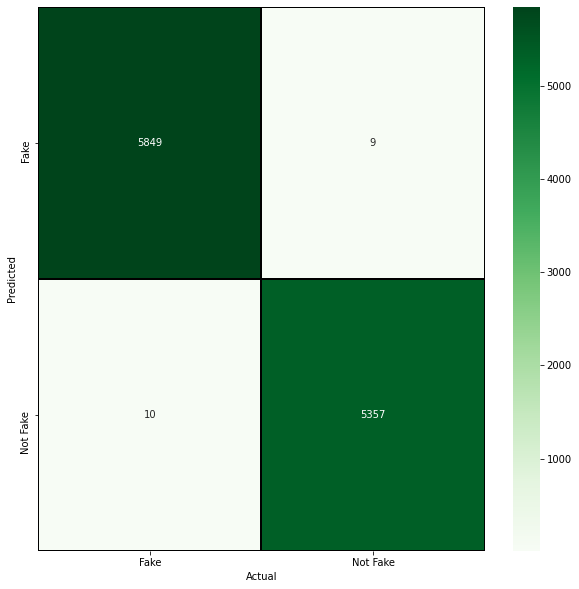

In [47]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Not Fake'] , yticklabels = ['Fake','Not Fake'])
plt.xlabel("Actual")
plt.ylabel("Predicted")